<a href="https://colab.research.google.com/github/yerimming/gachon/blob/main/CV_final_test4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   AdamP 사용
*   lr = 0.0001
*   batch = 64
*   CosineAnnealingLR 사용

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
!pip3 install adamp

In [11]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
from torchvision.transforms import RandAugment
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image,ImageFilter,ImageEnhance

from torch.utils.data import ConcatDataset
from collections import Counter

from adamp import AdamP

# 스케줄러 사용
from torch.optim.lr_scheduler import CosineAnnealingLR

import re

# 랜덤 시드 설정 공통
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [12]:
### Custom Dataset ###
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.transform = transform
    self.mode = mode

    if self.mode == 'train':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/CUB_200_2011_repackage_class50/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/CUB_200_2011_repackage_class50/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/CUB_200_2011_repackage_class50/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/content/gdrive/MyDrive/CUB_200_2011_repackage_class50/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)
    label = img_path.split('_')[-1].split('.')[0]
    label = re.sub(r'\([^)]*\)', '', label)
    label = int(label)
    return (img, label)

In [13]:
# Geomentric transform + Visual corruptions
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            img_array = np.array(img)
            noise = np.random.normal(self.mean, self.std, img_array.shape)
            noisy_image = np.clip(img_array + noise, 0, 255)  # Clip values to the range [0, 255]
            return Image.fromarray(noisy_image.astype(np.uint8))
        else:
            return img

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std}, p={self.p})'


class AdjustContrast(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

class AdjustBrightness(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'


# Mix up
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    # batch_size = x.size()[0]
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device, dtype=torch.long)  # GPU에 있는 x.device를 사용하여 인덱스를 GPU로 전송

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [16]:
BATCH_SIZE = 32

In [17]:
### Data Preprocessing ###
transforms_train_origin = transforms.Compose([transforms.Resize((448,448)),
                                       transforms.ToTensor()])
transforms_test = transforms.Compose([transforms.Resize((448,448)),
                                       transforms.ToTensor()])

# Apply RandAugment
transforms_train_rand = transforms.Compose([
    transforms.Resize((448, 448)),
    RandAugment(5,3),
    transforms.ToTensor()])

# Geomentric transform + Visual corruptions
transforms_train_g_v = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomResizedCrop(448),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(30),
    AddGaussianNoise(mean=0, std=25, p=0.5),  # 가우시안 노이즈를 추가합니다.
    AdjustContrast(factor=2.0),  # 대비를 조절합니다.
    AdjustBrightness(factor=1.5),  # 밝기를 조절합니다.
    transforms.ToTensor()])


train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

# 데이터 증강을 위해 원래 데이터를 복사하고 추가
train_set_augmented = CUB2011(mode='train', transform=transforms_train_rand)
train_set_augmented2 = CUB2011(mode='train',transform=transforms_train_g_v)

train_loader = DataLoader(train_set_origin,batch_size=BATCH_SIZE,shuffle=True)

# Mixup된 이미지를 train_loader에 추가
train_set_mixup = []
for input, target in train_loader:
    mixed_input, target_a, target_b, lam = mixup_data(input, target, alpha=1.0)
    train_set_mixup.extend([(mixed_input[i], target_a[i], target_b[i], lam) for i in range(len(input))])

train_set_mixup = transforms.Compose([transforms.Resize((448,448)),
                                       transforms.ToTensor()])

train_set_mixup = CUB2011(mode='train', transform=train_set_mixup)

#train_loader_mixup = DataLoader(train_set_mixup, batch_size=BATCH_SIZE, shuffle=True)

# 각 클래스의 샘플 수를 계산
class_counts = Counter([label for _, label in train_set_origin])

# 가장 작은 클래스의 샘플 수를 찾아 minority_class_label로 지정
minority_class_label = min(class_counts, key=class_counts.get)

# Create a new dataset from replicated_data
replicated_data = CUB2011(mode='train', transform=transforms_train_rand)
replicated_data.image_folder = [data for data in train_set_origin.image_folder if data[1] == minority_class_label]



# 두 데이터셋을 연결하여 새로운 훈련 데이터셋 생성
train_set_combined = ConcatDataset([train_set_origin, train_set_mixup])

print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))


#-----------------------------------------------------------------------
# Dataloader class는 bath기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 한다
# dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 된다
train_loader = DataLoader(train_set_combined, batch_size=BATCH_SIZE, shuffle=True)
# train_loader = DataLoader(train_set_combined, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")


Num of each dataset:  4724 296 298
Loaded dataloader


Batch 1


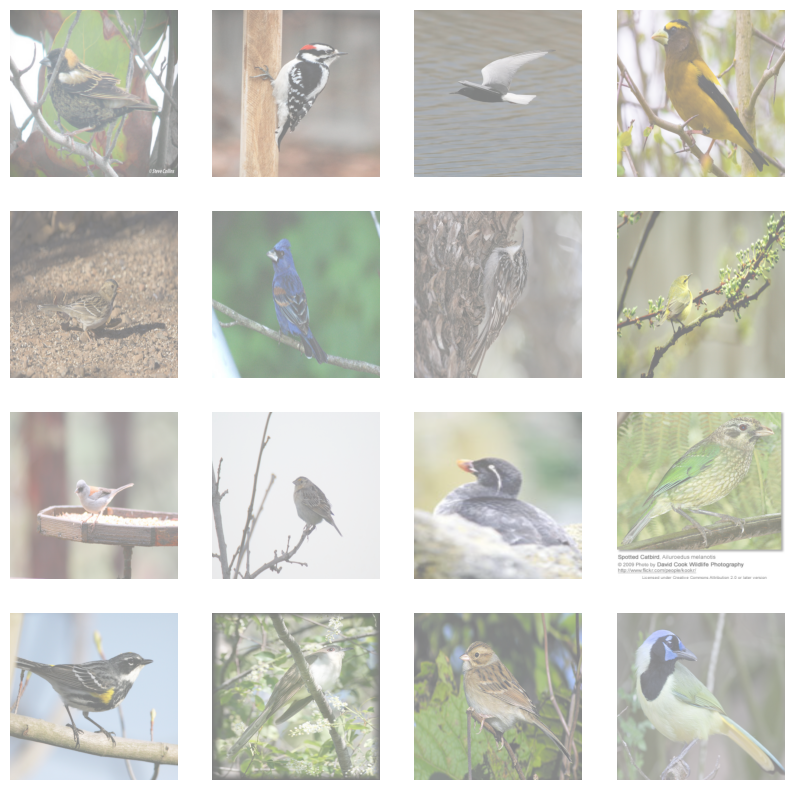

Batch 2


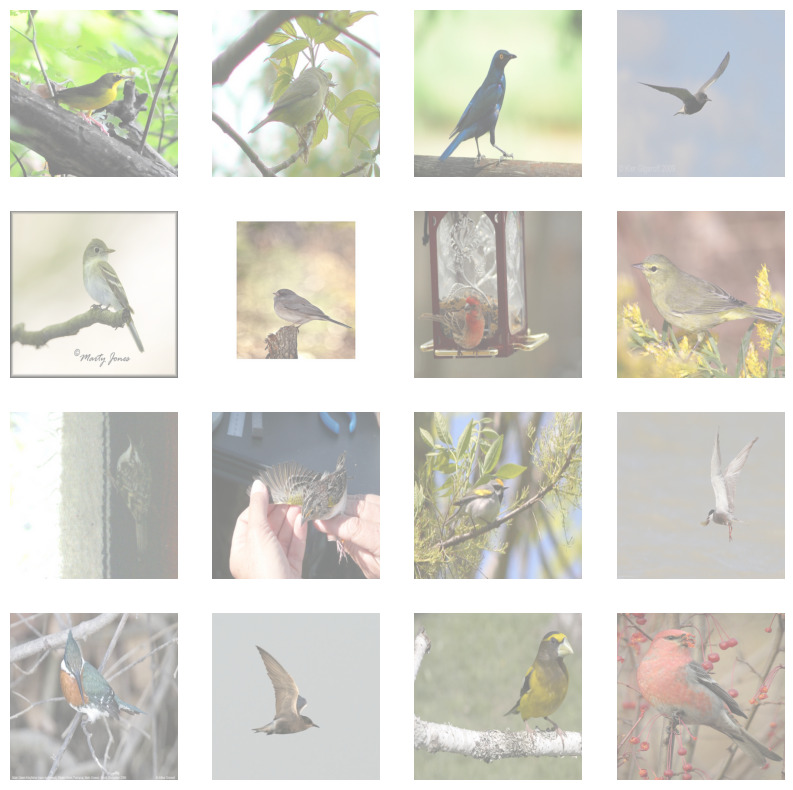

Batch 3


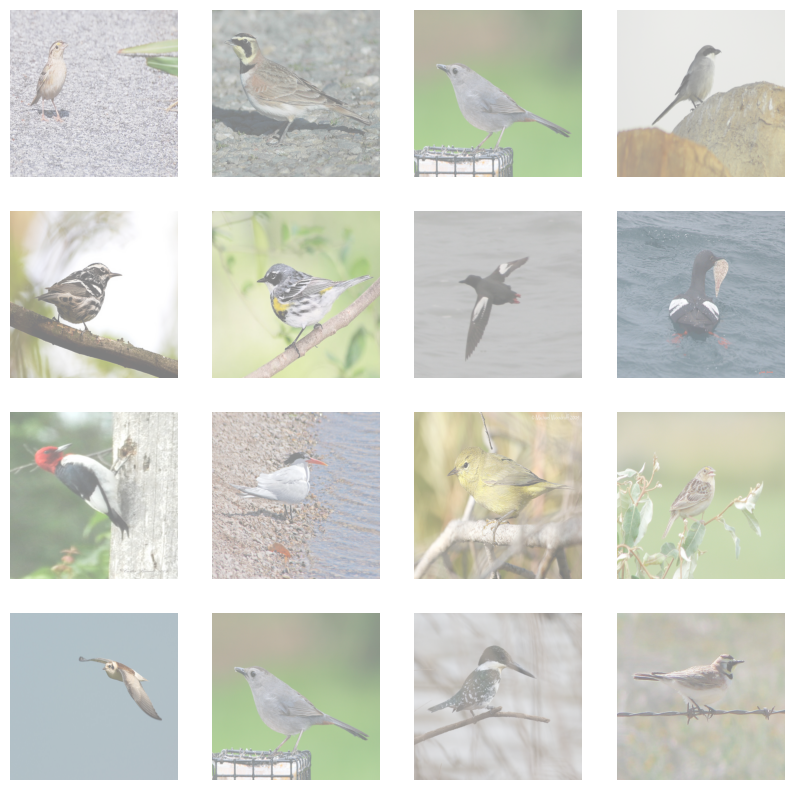

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of rows and columns for the grid
num_rows = 4  # You can change this to the desired number of rows
num_cols = 4  # You can change this to the desired number of columns

# Function to unnormalize and display a grid of images
def imshow_grid(images, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < len(images):
                img = images[index] / 2 + 0.5  # Unnormalize the image
                npimg = img.numpy()
                ax = axes[i, j]
                ax.imshow(np.transpose(npimg, (1, 2, 0)))
                ax.axis('off')

    plt.show()

# Iterate through the train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx >= 3:
        break  # Stop after visualizing the specified number of batches

    print(f"Batch {batch_idx + 1}")
    imshow_grid(images, num_rows, num_cols)  # Display the grid of images

In [19]:
### Model / Optimizer ###
EPOCH = 15
lr = 0.0001

model = models.resnet18(pretrained=True)

### Tranfer Learning ###
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,50)
model.to(DEVICE)

optimizer = AdamP(model.parameters(),lr=lr)

# 스케줄러 초기화 (주기와 최소/최대 학습률 설정)
dataset_size = len(train_set_combined)  # 훈련 데이터셋 크기

T_max = dataset_size / BATCH_SIZE  # 한 주기의 에폭 수
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=0.001)

print("Created a learning model and optimizer")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


Created a learning model and optimizer


In [20]:
### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch):
  model.train()
  for i,(image,target) in enumerate(train_loader):
    image,target = image.to(DEVICE),target.to(DEVICE)
    output = model(image)
    optimizer.zero_grad()
    # loss func을 어떤 것을 사용할 것인지?
    train_loss = F.cross_entropy(output,target).to(DEVICE)

    train_loss.backward()
    optimizer.step()

    # 스케줄러 업데이트
    scheduler.step()

    if i%10 ==0:
      print(
          f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  model.eval()
  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)
      output = model(image)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

In [21]:
### Main ###
start = time.time()
best = 0

train_losses = []  # 훈련 손실을 저장할 목록
val_losses = []    # 검증 손실을 저장할 목록
val_accuracys = []

# 디렉토리 생성
os.makedirs('./best_model', exist_ok=True)

for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch)
  val_loss,val_accuracy = evaluate(model,val_loader)

  # 훈련 및 검증 손실을 목록에 추가
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  val_accuracys.append(val_accuracy)
  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

Train Epoch: 0 [0/148]	loss: 3.949133
Train Epoch: 0 [10/148]	loss: 3.710844
Train Epoch: 0 [20/148]	loss: 3.112558
Train Epoch: 0 [30/148]	loss: 3.109183
Train Epoch: 0 [40/148]	loss: 2.820734
Train Epoch: 0 [50/148]	loss: 2.261792
Train Epoch: 0 [60/148]	loss: 1.881069
Train Epoch: 0 [70/148]	loss: 1.561637
Train Epoch: 0 [80/148]	loss: 1.315650
Train Epoch: 0 [90/148]	loss: 1.292659
Train Epoch: 0 [100/148]	loss: 1.129245
Train Epoch: 0 [110/148]	loss: 1.128348
Train Epoch: 0 [120/148]	loss: 1.034305
Train Epoch: 0 [130/148]	loss: 0.825809
Train Epoch: 0 [140/148]	loss: 0.937503
[0]Validation Loss: 2.1255,Accuracy: 42.2297%
Train Epoch: 1 [0/148]	loss: 1.122857
Train Epoch: 1 [10/148]	loss: 0.727562
Train Epoch: 1 [20/148]	loss: 0.686478
Train Epoch: 1 [30/148]	loss: 0.762159
Train Epoch: 1 [40/148]	loss: 0.505944
Train Epoch: 1 [50/148]	loss: 0.380638
Train Epoch: 1 [60/148]	loss: 0.683547
Train Epoch: 1 [70/148]	loss: 0.262857
Train Epoch: 1 [80/148]	loss: 0.267086
Train Epoch: 1 

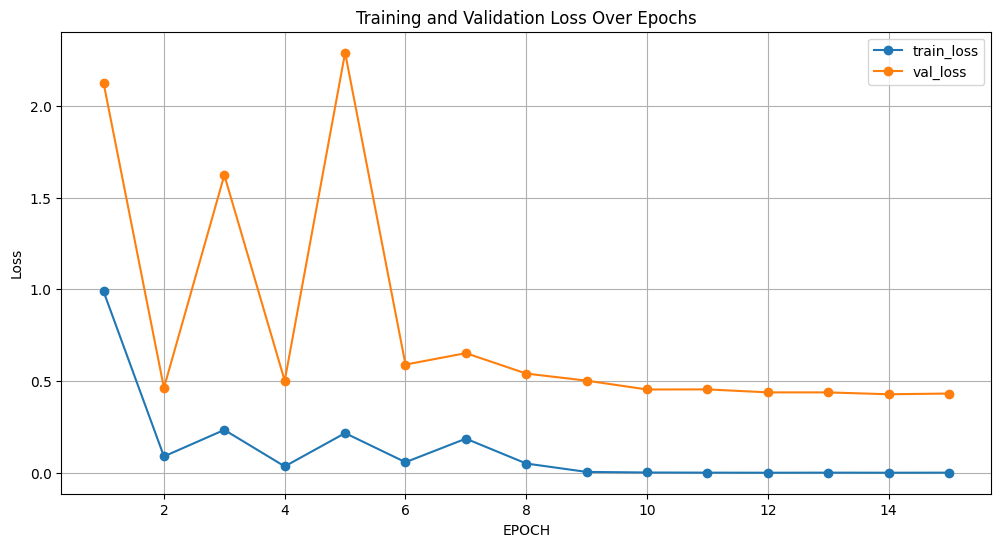

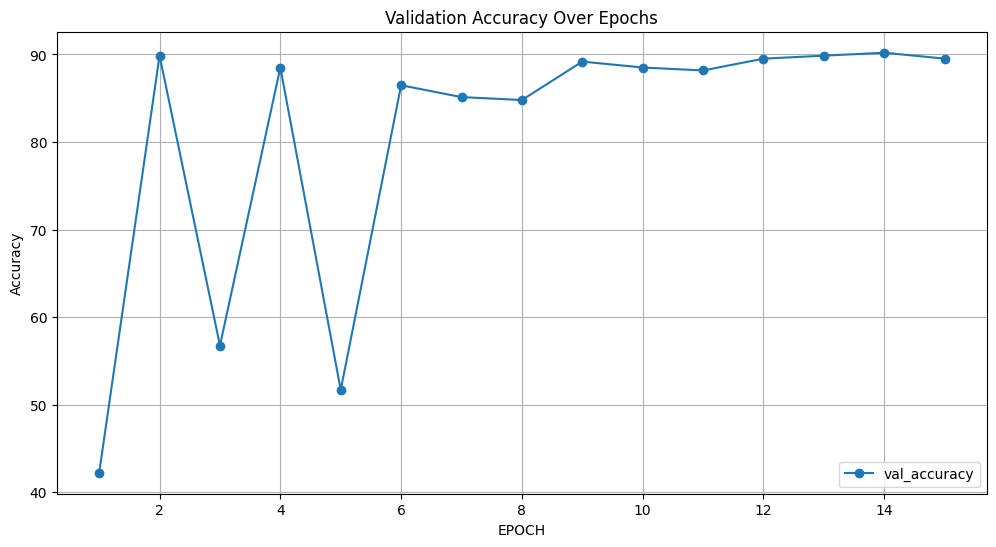

In [22]:
# 이제 손실 값을 플로팅합니다.
import matplotlib.pyplot as plt

# train_loss와 val_loss 텐서를 CPU로 이동하고 NumPy 배열로 변환
train_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), train_losses, label='train_loss', marker='o')
plt.plot(range(1, EPOCH + 1), val_losses, label='val_loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


val_accuracys = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracys]
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), val_accuracys, label='val_accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()